<a href="https://colab.research.google.com/github/sunny0103/online_course_or_book_reviewnote/blob/main/%5BDeep_Learning_from_Scratch%5D_2_Mnist_%EA%B5%AC%ED%98%84_Backpropagation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mnist Data
* OrderedDict은 순서가 있는 딕셔너리

In [ ]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import OrderedDict
%matplotlib inline

In [ ]:
mnist = load_digits()

In [ ]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [ ]:
pd.DataFrame(mnist.data, columns=mnist.feature_names).head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [ ]:
pd.DataFrame(mnist.target).head()

,0
0,0
1,1
2,2
3,3
4,4


In [ ]:
print('train data shape:',mnist.data.shape)
print('target data shape:',mnist.target.shape)

train data shape: (1797, 64)
target data shape: (1797,)


In [ ]:
print('data minimum:',mnist.data.min())
print('data maximum:',mnist.data.max())

data minimum: 0.0
data maximum: 16.0


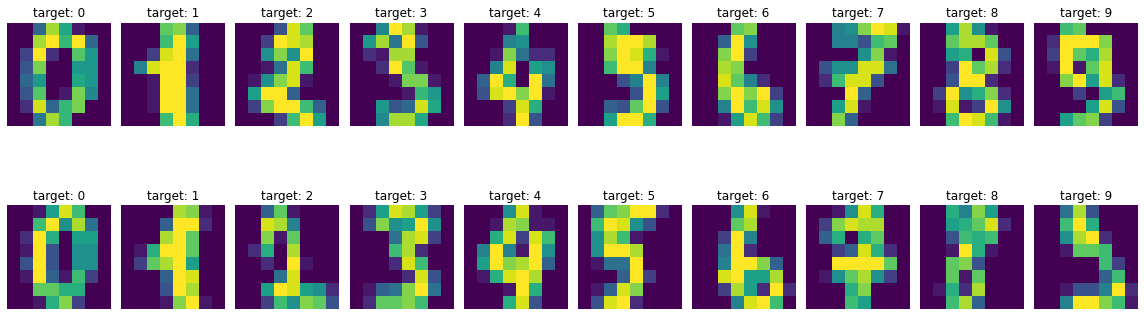

In [ ]:
fig, axes = plt.subplots(2, 10, figsize=(16, 6))
for i in range(20):
    axes[i//10, i %10].imshow(mnist.images[i]);
    axes[i//10, i %10].axis('off')
    axes[i//10, i %10].set_title(f"target: {mnist.target[i]}")
    
plt.tight_layout()

## Dataset modification

In [ ]:
# change dataset name to X and y
X = mnist.data
y = mnist.target

In [ ]:
X/=16.0
print(X.min(), X.max())

0.0 1.0


In [ ]:
# Split dataset into 3 : train, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)

(1437, 64) (360, 64)


## 2-layer Neural Network uisng Relu with Affine layers

In [ ]:
class Relu:
  def __init__(self):
    self.mask = None
  
  def forward(self, x):
    self.maks = (x<=0)
    out = x.copy()
    out[self.maks] =0
    return out

  def backward(self, dout):
    dout[self.maks] = 0
    dx = dout
    return dx


In [ ]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.original_x_shape = None
    self.dW = None
    self.db = None

  def forward(self, x):
    # 텐서대응
    self.original_x_shape = x.shape
    x = x.reshape(x.shape[0], -1)
    self.x = x
    out = np.dot(self.x, self.W) + self.b
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)

    dx = dx.reshape(*self.original_x_shape) # 입력데이터 모양으로 텐서 바꿈
    return dx

In [ ]:
def softmax(x):
  if x.ndim ==2:
    x = x.T
    x = x-np.max(x, axis=0)
    y = np.exp(x)/np.sum(np.exp(x), axis=0)
    return y.T
  x = x - np.max(x) # 오버플로 대책
  return np.exp(x)/ np.sum(np.exp(x))

In [ ]:
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  if t.size== y.size: # t가 원핫벡터라면
    t = t.argmax(axis=1)

  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7))

In [ ]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None # 손실함수
    self.y = None # softmax출력
    self.t = None #정답 레이블

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout = 1):
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size:  #정답이 원핫 인코딩일때
      dx = (self.y - self.t)/batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t]-=1
      dx = dx/batch_size
      return dx

In [ ]:
def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val  # 값 복원
        it.iternext()

    return grad

In [ ]:
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std =0.01):
    # 가중치 초기화
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    # 계층생성
    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
    self.lastLayer = SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x 

  def loss(self, x, t):
    y = self.predict(x)
    return self.lastLayer.forward(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1 : t = np.argmax(t, axis=1)
    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  def numerical_gradient(self, x, t):
    loss_W = lambda W :self.loss(x, t)

    grads ={}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
    return grads

  def gradient(self, x, t):
    # 순전파
    self.loss(x, t)

    # 역전파
    dout = 1
    dout = self.lastLayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    # 결과 저장
    grad = {}
    grad['W1'] = self.layers['Affine1'].dW
    grad['b1'] = self.layers['Affine1'].db
    grad['W2'] = self.layers['Affine2'].dW
    grad['b2'] = self.layers['Affine2'].db

    return grad

*** Gradient Check***

In [ ]:
network = TwoLayerNet(input_size=64, hidden_size = 32, output_size=10)
x_batch = X_train[:3]
t_batch = y_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 가중치 차이의 절대값을 구한후 평균
for key in grad_numerical.keys():
  diff = np.average(np.abs(grad_backprop[key]-grad_numerical[key]))
  print(key+":"+str(diff))

W1:0.002081848736642175
b1:0.006616825568554096
W2:0.00477271869293525
b2:0.32000420326349455


In [ ]:
network = TwoLayerNet(input_size = 64, hidden_size= 32, output_size=10)

In [ ]:
iters_num= 1000 # 반복횟수
train_size = X_train.shape[0]
batch_size = 100 # 미니배치 사이즈
learning_rate = 0.1

In [ ]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

In [ ]:
iter_per_epoch = int(max(train_size/batch_size, 1))

In [ ]:
for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = X_train[batch_mask]
  t_batch = y_train[batch_mask]

  grad = network.gradient(x_batch, t_batch)

  for key  in ('W1', 'b1','W2', 'b2'):
    network.params[key] -= learning_rate*grad[key]

  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(X_train, y_train)
    test_acc = network.accuracy(X_test, y_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(train_acc, test_acc)

0.1057759220598469 0.08055555555555556
0.11760612386917188 0.07777777777777778
0.10995128740431455 0.06666666666666667
0.10995128740431455 0.06666666666666667
0.10995128740431455 0.06666666666666667
0.10995128740431455 0.06666666666666667
0.22477383437717466 0.1638888888888889
0.3757828810020877 0.3111111111111111
0.33820459290187893 0.2833333333333333
0.41196938065414057 0.35555555555555557
0.4759916492693111 0.4083333333333333
0.47947112038970074 0.41388888888888886
0.5267919276270007 0.4583333333333333
0.5553235908141962 0.5
0.6033402922755741 0.5277777777777778
0.7807933194154488 0.7722222222222223
0.7752261656228253 0.7694444444444445
0.7988865692414753 0.7666666666666667
0.8281141266527487 0.8055555555555556
0.8413361169102297 0.8416666666666667
0.8649965205288797 0.8416666666666667
0.8733472512178149 0.8416666666666667
0.8747390396659708 0.8527777777777777
0.8740431454418929 0.8444444444444444
0.883785664578984 0.8666666666666667
0.883785664578984 0.8555555555555555
0.8893528183

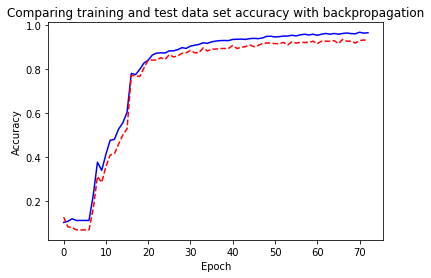

In [ ]:
plt.plot(train_acc_list,'-b')
plt.plot(test_acc_list,'--r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Comparing training and test data set accuracy with backpropagation')
plt.show()